## Importing libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.xception import preprocess_input
import cv2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps

## Reading data

In [2]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [3]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [4]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [12]:
# Load pre-trained model without top classifier layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# base_model.trainable = True
# for layer in base_model.layers[:-3]:
#     layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [13]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - loss: 21067.5176 - mae: 109.9122 - val_loss: 10824.0420 - val_mae: 70.9580
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - loss: 10728.8848 - mae: 76.0392 - val_loss: 9528.7900 - val_mae: 75.0825
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - loss: 9568.1592 - mae: 74.6472 - val_loss: 9010.3721 - val_mae: 69.2732
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - loss: 9163.9180 - mae: 70.3699 - val_loss: 8830.0938 - val_mae: 65.2421
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - loss: 8671.3145 - mae: 67.0179 - val_loss: 8322.4209 - val_mae: 63.5103
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - loss: 8127.5352 - mae: 65.5201 - val_loss: 7957.9478 - val_mae: 61.6812
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - loss: 8103.7153 - mae: 66.6101 - val_loss: 7733.5015 - val_mae: 59.2046
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - loss: 7722.6797 - mae: 61.9955 - val_loss: 7478.4321 - val_mae: 57.5559
Epoc

## Training curves visualisation

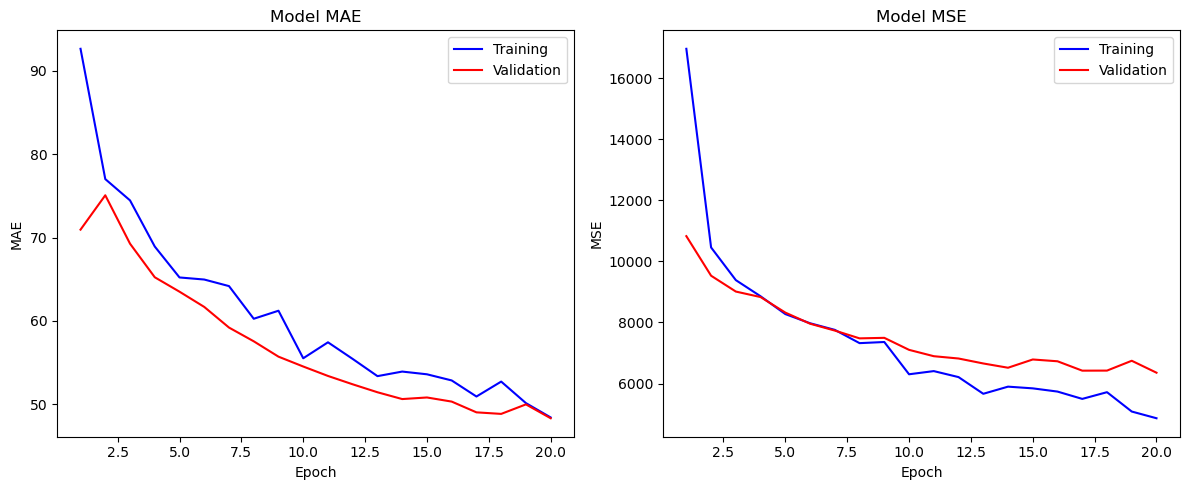

In [14]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [15]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step


In [16]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 32.  23.]
 [107. 181.]
 [146. 157.]
 [ 36.  37.]
 [149.  70.]
 [105.  57.]
 [ 29.  44.]
 [164. 227.]
 [125. 165.]
 [145. 476.]
 [ 97. 139.]
 [150. 316.]
 [132. 164.]
 [ 92. 110.]
 [ 42.  20.]
 [111. 131.]
 [ 52.  48.]
 [152. 183.]
 [102. 101.]
 [186. 204.]
 [ 66.  40.]
 [ 78. 143.]
 [ 94. 146.]
 [136. 513.]
 [ 61.  70.]
 [ 95. 175.]
 [ 51.  51.]
 [ 84.  55.]
 [ 99.  67.]
 [ 98.  72.]
 [ 48.  56.]
 [123. 165.]
 [ 18.  32.]
 [ 86. 149.]
 [ 88.  48.]
 [ 65.  80.]
 [102. 117.]
 [ 51. 162.]
 [119. 137.]
 [130. 120.]
 [122.  72.]
 [131. 122.]
 [101. 198.]
 [ 70. 133.]
 [ 92. 147.]
 [ 61.  29.]
 [ 24.  70.]
 [ 45.  35.]
 [ 21.  24.]
 [137. 251.]
 [ 93.  59.]
 [ 90.  67.]
 [ 55.  61.]
 [141. 248.]
 [174. 252.]
 [140. 147.]
 [ 44.  57.]
 [ 96. 121.]
 [ 14.  47.]
 [203. 505.]
 [166. 297.]
 [168. 465.]
 [131. 167.]
 [ 67.  43.]
 [ 34.  46.]
 [ 96.  91.]
 [112. 263.]
 [ 69.  92.]
 [128. 117.]
 [ 50.  48.]
 [ 91.  54.]
 [ 85.  73.]
 [127. 122.]
 [113.  60.]
 [151. 170.]
 [ 50. 167.]
 [ 28.  57.]

## Metrics

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.29757940769195557
MSE: 6357.00927734375
MAE: 48.332279205322266
RMSE: 79.7308578491211
